# Magnetization Transfer saturation estimation at Siemens 3T
#### Last updated on: 06/09/2019
#### Rakshit

__Magnetization Transfer data fitting__

In [52]:
# Import important libraries
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom as dicom
from natsort import natsorted
%matplotlib inline

import nipype.interfaces.mrtrix3 as mrt

# load MRI measurements scan list csv file
csv_path = "/home/rdadarwal/DPZ/common/Studies/FID_old-Javaner-females/RAKSHIT_data_analysis_TP2/"
csv_file = 'ScanList_MT_test.csv'
csv_filepath = os.path.join(csv_path,csv_file)
Siemens_meas = pd.read_csv(csv_filepath,na_values='scalar')

# T1, MT, and PD measurement number
T1_meas_nr = (Siemens_meas['T1']).astype(int)
MT_meas_nr = (Siemens_meas['MT']).astype(int)
PD_meas_nr = (Siemens_meas['PD']).astype(int)
# macaque measurement number (mac_0)
mac_nr = (Siemens_meas['MR_Number']).astype(int)

for mac in mac_nr.index:
    if os.path.exists("/mnt/scanner/siemens/macaque/mac_0"+str(mac_nr[mac])+"/dicom"):
        acq_path = "/mnt/scanner/siemens/macaque/mac_0"+str(mac_nr[mac])+"/dicom"

        if os.path.exists(acq_path):
            # Study folder path for each subject
            data_path = os.path.join(csv_path+"MT/")
            
            T1_dicom_nr = 'M-0'+str(mac_nr[mac])+'-00'+str(T1_meas_nr[mac])+'-0'
            MT_dicom_nr = 'M-0'+str(mac_nr[mac])+'-00'+str(MT_meas_nr[mac])+'-0'
            PD_dicom_nr = 'M-0'+str(mac_nr[mac])+'-00'+str(PD_meas_nr[mac])+'-0'
            
            # check the existence of empty subject directory in the study folder
            if not os.path.exists(data_path+"mac_0"+str(mac_nr[mac])):
                # make empty directory 
                os.mkdir(os.path.join(data_path+"mac_0"+str(mac_nr[mac])))
                
            # check the existence of empty T1 directory in the study folder
            if not os.path.exists(data_path+"mac_0"+str(mac_nr[mac])+"/T1"):
                # make empty directory 
                os.mkdir(os.path.join(data_path+"mac_0"+str(mac_nr[mac])+"/T1"))
            
            # Create separate folder for differenct slice packages
            T1_save_path = os.path.join(data_path+"mac_0"+str(mac_nr[mac])+"/T1")
            
             # check the existence of empty MT directory in the study folder
            if not os.path.exists(data_path+"mac_0"+str(mac_nr[mac])+"/MT"):
                # make empty directory 
                os.mkdir(os.path.join(data_path+"mac_0"+str(mac_nr[mac])+"/MT"))
            
            # Create separate folder for differenct slice packages
            MT_save_path = os.path.join(data_path+"mac_0"+str(mac_nr[mac])+"/MT")
            
            # check the existence of empty PD directory in the study folder
            if not os.path.exists(data_path+"mac_0"+str(mac_nr[mac])+"/PD"):
                # make empty directory 
                os.mkdir(os.path.join(data_path+"mac_0"+str(mac_nr[mac])+"/PD"))
            
            # Create separate folder for differenct slice packages
            PD_save_path = os.path.join(data_path+"mac_0"+str(mac_nr[mac])+"/PD")
            
            # copy T1 dicom files into save path folder
            !cp $acq_path/$T1_dicom_nr* $T1_save_path/
            # copy MT dicom files into save path folder
            !cp $acq_path/$MT_dicom_nr* $MT_save_path/
            # copy PD dicom files into save path folder
            !cp $acq_path/$PD_dicom_nr* $PD_save_path/
            
            #======================================================================================
            # read dicom files with header
            
            def read_dicom(path):
                lstFiles = [] # create an empty list
                for ddir, subdirList, fileList in os.walk(path):
                    for filename in natsorted(fileList): # sorted filenames
                        if ".dcm" in filename.lower(): # check weather the file's DICOM
                            lstFiles.append(os.path.join(ddir,filename)) 

                # Get ref file
                Ref = dicom.read_file(lstFiles[0])
                read_dicom.Ref = Ref
                
                # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
                ConstPixelDims = (int(Ref.Rows), int(Ref.Columns), len(lstFiles))
                read_dicom.ConstPixelDims = ConstPixelDims

                # Load acquisition parameters
                FA = np.deg2rad(Ref.FlipAngle); TE = Ref.EchoTime; NA = Ref.NumberOfAverages; TR = Ref.RepetitionTime

                # Load spacing values (in mm)
                ConstPixelSpacing = (float(Ref.PixelSpacing[0]), 
                                     float(Ref.PixelSpacing[1]), 
                                     float(Ref.SliceThickness))
                 # The array is sized based on 'ConstPixelDims'
                dicom_data = np.zeros(ConstPixelDims, dtype=Ref.pixel_array.dtype)

                # loop through all the DICOM files
                for filename in lstFiles:
                    # read the file
                    ds = dicom.read_file(filename)
                    # store the raw image data
                    dicom_data[:, :, lstFiles.index(filename)] = ds.pixel_array 
                
                return dicom_data, FA, TE, NA, TR 
            
            # T1, MT, and PD dicom files with their hdr information
            T1dicom, FAt1, TEt1, NAt1, TRt1 = read_dicom(T1_save_path)
            MTdicom, FAmt, TEmt, NAmt, TRmt = read_dicom(MT_save_path)
            PDdicom, FApd, TEpd, NApd, TRpd = read_dicom(PD_save_path)
                
            #==========================================================================================
            # MTR estimation
            
            # The array is sized based on 'ConstPixelDims'
            PDmMT = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            MTR = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            
            # loop through all the slices
            for slice in range(0,read_dicom.ConstPixelDims[2]):
                PDmMT[:,:,slice] = PDdicom[:,:,slice] - MTdicom[:,:,slice]
                MTR[:,:,slice] = (PDmMT[:,:,slice] / PDdicom[:,:,slice])*100
            
            #==========================================================================================
            # MT saturation parameter estimation       
            
            T1app = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            Aapp = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            MTsat = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            # calculate apparent T1
            for slice in range(0,read_dicom.ConstPixelDims[2]):
                T1app[:,:,slice] = 2*((PDdicom[:,:,slice]/FApd)-(T1dicom[:,:,slice]/FAt1))/(T1dicom[:,:,slice]*FAt1/TRt1 - PDdicom[:,:,slice]*FApd/TRpd)
                Aapp[:,:,slice] = ((T1dicom[:,:,slice]*PDdicom[:,:,slice])/(PDdicom[:,:,slice]*FApd - T1dicom[:,:,slice]*FAt1))*(FApd/FAt1 - (FAt1/FApd))
                MTsat[:,:,slice] = ((Aapp[:,:,slice]*FAmt)/ (MTdicom[:,:,slice] -1))/(T1app[:,:,slice]*TRmt - (FAmt**2)/2)
                                   
            #==========================================================================================
            # save paramter maps
            #nib.save(MTR, os.path.join(T1_save_path,'MTR.nii.gz'))
            #nib.save(T1app, os.path.join(T1_save_path,'T1app.nii.gz'))
            #nib.save(Aapp, os.path.join(T1_save_path,'Aapp.nii.gz'))
            #nib.save(MTsat, os.path.join(T1_save_path,'MTsat.nii.gz'))
            #MTR.to_filename(os.path.join(T1_save_path,'MTR.nii.gz'))
            

/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in true_divide
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in true_divide
/home/rdadarwal/anaconda3/lib/

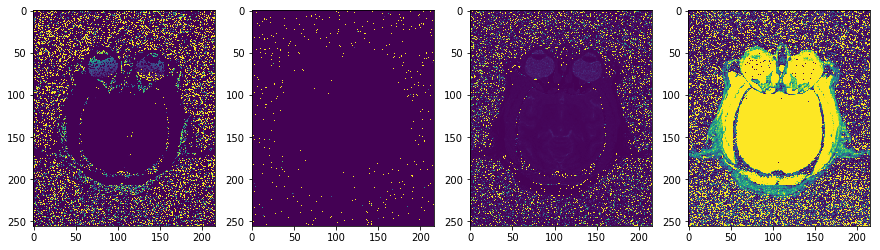

In [48]:
fig, [ax0, ax1, ax2, ax3] = plt.subplots(1,4,figsize=(15,8))
ax0.imshow(MTR[:,:,60])
ax1.imshow(MTsat[:,:,60])
ax2.imshow(T1app[:,:,60])
ax3.imshow(Aapp[:,:,60], vmin=10, vmax=1140)

In [1]:
read_dicom.Ref.pixel_array.dtype

NameError: name 'read_dicom' is not defined

In [45]:
T1app = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
Aapp = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)

for slice in range(0,read_dicom.ConstPixelDims[2]):
    T1app[:,:,slice] = 2*((PDdicom[:,:,slice]/FApd)-(T1dicom[:,:,slice]/FAt1))/(T1dicom[:,:,slice]*FAt1/TRt1 - PDdicom[:,:,slice]*FApd/TRpd)
    Aapp[:,:,slice] = ((T1dicom[:,:,slice]*PDdicom[:,:,slice])/(PDdicom[:,:,slice]*FApd - T1dicom[:,:,slice]*FAt1))*(FApd/FAt1 - (FAt1/FApd))

/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/rdadarwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
